# Introduction

A common model that seems to fit many datasets well is Gaussian Mixtures.  However, it is an often-overlooked algorithm, regularly losing out to other, more popular algorithms.  Despite the fact that it can be used for both classification and clustering, many people often forget about the potential for classification.  For instance, consider the artificial data set below:

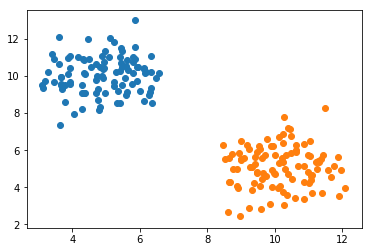

In [1]:
import matplotlib.pyplot as plt
import numpy as np
class_1 = np.random.multivariate_normal([5,10], [[1,0],[0,1]], 100)
class_2 = np.random.multivariate_normal([10,5], [[1,0],[0,1]], 100)
plt.scatter(class_1[:,0], class_1[:,1])
plt.scatter(class_2[:,0], class_2[:,1])
plt.show()

Far too many people, upon seeing data like this, would notice that the data is linearly separable and use a support vector machine or other linear classifier.  Of course, the data need not be linearly separable when gaussian in nature, but often such data is.  When trying to make predictions with a data set like this, linear classifiers have a simple flaw: Most linear classifiers do not provide probability estimates.  When they do, the estimates tend to be the same for all points at a given distance from the decision surface, which tends to not be accurate in circular data.  If your model recieved the data point $(100, 4)$, would your model output that it was 99.9% certain that it was in the orange group?  Or would it instead assign a low probability of being orange and a low probability of being blue?

Even if you know that orange and blue are the only two possible classes, it still may be useful, when you recieve the data point $(100, 4)$, to ask the user if they are sure that they meant it, because it seems likely that they made a mistake.  

# The basic gaussian mixture model for classification

Surprisingly, most libraries, such as scikit-learn, don't provide built-in methods for gaussian mixture models for classification.  They do for clustering, however the algorithm for classification is much simpler and easier to understand.  To fit, one simply computes the means, covariance matricies, and number of occurances of each class label.  To classify, one simply checks the pdf of each fitted gaussian model, and normalizes the probability densities weighted by the number of occurances

In [2]:
from scipy.stats import multivariate_normal # just a class for dealing with multivariate gaussian distributions
class GaussianMixture: 
    def fit(self, X, y):
        """ Construct a Gaussian Mixture Model mapping inputs X to class labels y.
            Each row in X is a sample, each column is a different dimension. """
        # means and covariance_matricies are dictionaries that map class labels to the means and covariance matricies
        # fitted to each class
        self.means = {}
        self.covariance_matricies = {}
        # compute the class labels
        self.class_labels = set(y)
        for class_label in self.class_labels: 
            # compute the mean of X values constrained by class_label
            self.means[class_label] = X[np.where(y == class_label)].mean(axis=0) 
            # compute the covariance matrix of X values constrained by class_label
            self.covariance_matricies[class_label] = np.cov(X[np.where(y == class_label)].T)
    
    def predict(self, x):
        """ Make predictions based on the known means and covariance matricies for input x
            x should be a single data point, return value is a dictionary from class labels to probabilities """
        res = {}
        for class_label in self.class_labels:
            res[class_label] = multivariate_normal.pdf(x, self.means[class_label], self.covariance_matricies[class_label])
        return res

The core algorithm is incredibly simple - just compute each class's mean and covariance, and use that to make predictions.  The benefit of this is clear when we use it on the contrived 2d dataset above:

In [3]:
X = np.concatenate((class_1, class_2))
y = np.array((["blue"] * 100) + (["orange"] * 100))
model = GaussianMixture()
model.fit(X, y)
print(model.predict([100, 4]))

{'blue': 0.0, 'orange': 0.0}


Indeed, if we were to modify the code so that it would produce a hard decision surface based on the probability densities, with two classes, the decision surface would likely be linear, however, directly using the probability densities provides a much more useful result - that the point $(100, 4)$ likely was not generated from the same distribution as the training data from which the model was built.  When designing an application, this would be a great time to ask the user if they actually meant to input $(10, 4)$.

Of course, two values that approximate to 0 isn't the most useful result, so using the log of the pdf may be more useful, e.g.:

In [4]:
for class_label in model.class_labels:
    print(class_label, multivariate_normal.logpdf([100, 4], model.means[class_label], model.covariance_matricies[class_label]))

blue -5321.18392069
orange -4719.33540458


If one needed to perform a classification on the data point, one would choose orange over blue, but one should only do so grudgingly, noting that it highly unlikely that the data point is either.  Even if the classes correspond to something as black and white as "cancer/not cancer", a response of neither is still valid, indicating errors in collecting the data.

# Downsides to Gaussian Mixtures

## Inaccurate covariance matricies

Take a quick look at the means and covariance matricies:

In [5]:
print(model.means)

{'blue': array([  4.91087957,  10.05129721]), 'orange': array([ 10.13663288,   5.10937089])}


In [6]:
print(model.covariance_matricies["blue"])

[[ 0.8675968   0.07907704]
 [ 0.07907704  1.00542299]]


In [7]:
print(model.covariance_matricies["orange"])

[[ 0.8585955   0.04806594]
 [ 0.04806594  1.28009927]]


Note that although the means are fairly accurate, the values in the covariance matricies differ quite widely from the true values, thus a large sample size is needed for more accurate estimates.  

## Quadratically many parameters in the number of dimensions

The most obvious downside to a gaussian mixture model is that the number of parameters is quadratic in the number of dimensions, thus the number of samples needed to make accurate estimates on data increases quadratically with the number of dimensions.  However, there are a few tricks to get around this:

1. Make assumptions, such as assuming various variables are uncorrelated.  This requires manual tuning and expertise, but may result in a more accurate model.
2. Assume that all variables are uncorrelated.  This is an extreme version of #1, which results in a diagonal covariance matrix.  The number of parameters is now linear in the number of dimensions, but the model is no longer able to capture much useful data.  The most extreme version of this also assumes that all variables have the same variance as well (a "spherical model"), which is often useful, but not always realistic.  I prefer the method of:
3. Principal component analysis or some other dimensionality reduction method.

Suprisingly many natural datasets project down nicely into one or more gaussian clusters, thus even with high dimensional data, the gaussian mixture model can often be used for classification.  For instance, consider another artificial data set in 1000 dimensions, projected back to 2 dimensions:

C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


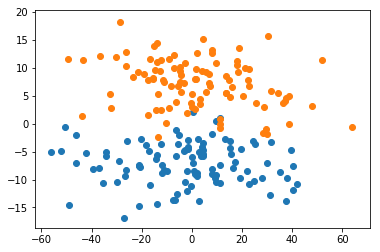

In [8]:
from sklearn.decomposition import PCA
ground_truth_class_1_mean = np.random.random(1000)
ground_truth_class_1_cov = np.random.random((1000, 1000))
ground_truth_class_2_mean = np.random.random(1000)
ground_truth_class_2_cov = np.random.random((1000, 1000))
class_1_train = np.random.multivariate_normal(ground_truth_class_1_mean, ground_truth_class_1_cov, 100)
class_2_train = np.random.multivariate_normal(ground_truth_class_2_mean, ground_truth_class_2_cov, 100)
X_train = np.concatenate((class_1_train, class_2_train))
pca_model = PCA(2)
Xlo_train = pca_model.fit_transform(X_train)
plt.scatter(Xlo_train[:100, 0], Xlo_train[:100, 1])
plt.scatter(Xlo_train[100:, 0], Xlo_train[100:, 1])
plt.show()

Despite having far fewer samples than dimensions, and the data being generated from far more parameters than there were samples, simple principal component analysis is able to easily decompose the data into visually distinct gaussian clusters.  A healthy skeptic might suggest that the PCA model is simply overfitting to the samples, but generating new data shows that this isn't true:

C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.
C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


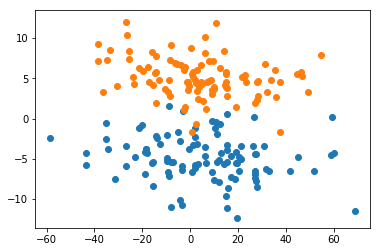

In [9]:
class_1_test = np.random.multivariate_normal(ground_truth_class_1_mean, ground_truth_class_1_cov, 100)
class_2_test = np.random.multivariate_normal(ground_truth_class_2_mean, ground_truth_class_2_cov, 100)
X_test = np.concatenate((class_1_test, class_2_test))
Xlo_test = pca_model.transform(X_test)
plt.scatter(Xlo_test[:100, 0], Xlo_test[:100, 1])
plt.scatter(Xlo_test[100:, 0], Xlo_test[100:, 1])
plt.show()

If we fit a gaussian mixture model to the training data and use it to hard-line classify data in the test set as either blue or orange, we find a quite reasonable classification accuracy:

In [10]:
model = GaussianMixture()
y_train = np.array((["blue"] * 100) + (["orange"] * 100))
model.fit(Xlo_train, y_train)
correct = 0
for i in range(200):
    prediction = model.predict(Xlo_test[i, :]) 
    if i < 100 and prediction["blue"] > prediction["orange"]:
        correct += 1
    if i >= 100 and prediction["blue"] < prediction["orange"]:
        correct += 1
print(correct / 2, "%")

95.0 %


I encourage you to run this code for yourself a few times so that you can see that it isn't a fluke.

# Incorporating priors

The intuition behind a prior probability is as follows:  Consider two kinds of flowers, one rare and one common, and suppose that a classifier recieves an example that is equally likely to have come from either flower.  The one the classifier should pick, then, is the common flower, since it has the highest probability of being correct.  The model that I have outlined thus far does not incorporate these probabilities.

The gaussian mixture model that I have outlined thus far is what I call a "maximum liklihood gaussian mixture model", because it makes no assumptions about how often one classification occurs over another.  This model, while naive, is especially useful when training data is gathered in a different manner from the data that the model is used for, for instance, a cancer / not cancer classifier may have a large number of instances of "not cancer" data in the training set since most people don't have cancer, but most people who ask for a test to be performed will have a much higher probability than the base rate of having cancer, thus prior probabilities trained on the training set would dangerously misclassify many cancer patients as not cancer.  Further, even if the correct priors were used, true probabilities might not be desired anyway, since the penalty for a false negative is much worse than the penalty for a false positive.

However, many data sets are sampled sufficiently to offer an accurate estimation of priors, and make sense to do so, such as the flower example outlined above.  Such an estimation is easy to create, but use of priors removes the benefit of outlier detection in new data, since it inherently normalizes the probabilities so that they sum to one.  (The reason for this is that, based on the training data, the probability of an outlier is 0.)  One can combine the two methods, by checking to make sure that the liklihood is above a certain threshold and assigning a classification of "outlier" if it isn't, but that is beyond the scope of this tutorial.

A sample implementation of a gaussian mixture model that uses priors is shown below, requiring few modifications from the original:

In [11]:
from collections import Counter # Like a set, but tracks number of occurances as well
class BayesianGaussianMixture: # Bayes invented priors, everything that uses them is named in his honor
    def fit(self, X, y):
        """ Construct a Gaussian Mixture Model mapping inputs X to class labels y.
            Each row in X is a sample, each column is a different dimension. """
        # means and covariance_matricies are dictionaries that map class labels to the means and covariance matricies
        # fitted to each class
        self.means = {}
        self.covariance_matricies = {}
        self.counts = Counter(y)
        # compute the class labels
        self.class_labels = set(y)
        for class_label in self.class_labels: 
            # compute the mean of X values constrained by class_label
            self.means[class_label] = X[np.where(y == class_label)].mean(axis=0) 
            # compute the covariance matrix of X values constrained by class_label
            self.covariance_matricies[class_label] = np.cov(X[np.where(y == class_label)].T)
    
    def predict(self, x):
        """ Make predictions based on the known means and covariance matricies for input x
            x should be a single data point, return value is a dictionary from class labels to probabilities """
        res = {}
        normalization_factor = 0 # the thing that you divide by to make everything sum to one
        for class_label in self.class_labels:
            res[class_label] = multivariate_normal.pdf(x, self.means[class_label], self.covariance_matricies[class_label]) \
                                * self.counts[class_label]
            normalization_factor += res[class_label]
        try: 
            for class_label in self.class_labels:
                res[class_label] /= normalization_factor
        except ZeroDivisionError:
            pass
        return res

For a concrete example of data that has meaningful prior probabilities, consider the following data, generated the same way as the high-dimensional data from before, except with twenty times as many orange points.

C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """
C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


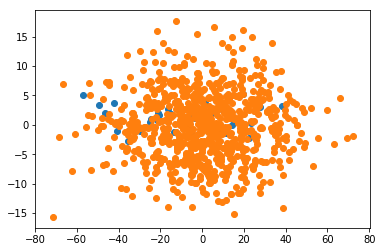

In [12]:
ground_truth_class_1_mean = np.random.random(1000)
ground_truth_class_1_cov = np.random.random((1000, 1000))
ground_truth_class_2_mean = np.random.random(1000)
ground_truth_class_2_cov = np.random.random((1000, 1000))
class_1_train = np.random.multivariate_normal(ground_truth_class_1_mean, ground_truth_class_1_cov, 40)
class_2_train = np.random.multivariate_normal(ground_truth_class_2_mean, ground_truth_class_2_cov, 800)
X_train = np.concatenate((class_1_train, class_2_train))
pca_model = PCA(2)
Xlo_train = pca_model.fit_transform(X_train)
plt.scatter(Xlo_train[:40, 0], Xlo_train[:40, 1])
plt.scatter(Xlo_train[40:, 0], Xlo_train[40:, 1])
plt.show()

First, notice that it is very difficult visually to distinguish classes when dimensionality reduction is conducted via naive principal component analysis, and the optimal classifier in this low-dimensional space appears to be to simply classify everything as orange.  There are a few ways to handle this, the most obvious being to use a different dimensionality reduction system that is aware of the classes.  However, such algorithms are too complicated and beyond the scope of this tutorial, so we will use a much simpler trick - conduct the dimensionality reduction on equal size samples of each class.

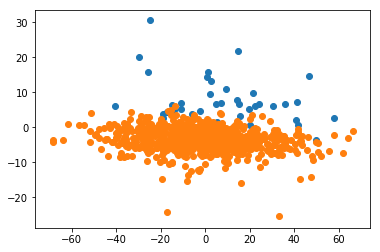

In [13]:
X_train = np.concatenate((class_1_train, class_2_train))
pca_model = PCA(2)
pca_model.fit(np.concatenate((class_1_train, class_2_train[:40])))
Xlo_train = pca_model.transform(X_train)
plt.scatter(Xlo_train[:40, 0], Xlo_train[:40, 1])
plt.scatter(Xlo_train[40:, 0], Xlo_train[40:, 1])
plt.show()

This data is much easier to handle.  Now, we once again construct a test set and examine it:

C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.
C:\Users\jackw\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


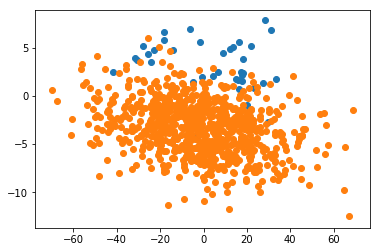

In [14]:
class_1_test = np.random.multivariate_normal(ground_truth_class_1_mean, ground_truth_class_1_cov, 40)
class_2_test = np.random.multivariate_normal(ground_truth_class_2_mean, ground_truth_class_2_cov, 800)
X_test = np.concatenate((class_1_test, class_2_test))
Xlo_test = pca_model.transform(X_test)
plt.scatter(Xlo_test[:40, 0], Xlo_test[:40, 1])
plt.scatter(Xlo_test[40:, 0], Xlo_test[40:, 1])
plt.show()

The data is still visually distinct, but there is substantial overlap between the two classes.  The intuition about priors should now become clear - when in the overlapping region between the two classes, the algorithm should tend to classify as orange since orange is more common.  Lets see if this translates into improved classification accuracy:

In [15]:
for GaussianAlgorithm in [GaussianMixture, BayesianGaussianMixture]:
    model = GaussianAlgorithm()
    y_train = np.array((["blue"] * 40) + (["orange"] * 800))
    model.fit(Xlo_train, y_train)
    correct = 0
    for i in range(840):
        prediction = model.predict(Xlo_test[i, :]) 
        if i < 40 and prediction["blue"] > prediction["orange"]:
            correct += 1
        if i >= 40 and prediction["blue"] < prediction["orange"]:
            correct += 1
    print(GaussianAlgorithm.__name__, ":", correct / 840 * 100, "%")

GaussianMixture : 95.47619047619048 %
BayesianGaussianMixture : 96.30952380952381 %


Although slight, the difference is there.  If you run this multiple times, you'll find a consistent improvement in classification accuracy of about 1%.  Once again, however, if the blue dots represent people with cancer, you might want to sacrifice classification accuracy for a lower false-negative rate, and stick with the regular gaussian mixture model.

# Conclusion

For data that is gaussian in nature, there is very litle reason to use any model of classification other than the mixture of gaussians.  Gaussian mixtures can detect outliers far better than more popular linear classifiers.  High dimensional data can be generally projected down to lower dimensions, and an accurate model trained even if the original data has more dimensions than samples.  Covariance matricies can vary widely from the true value at low sample sizes, but are still accurate enough to tend to produce correct predictions.  Adding in basic accounting for priors allows for higher classification accuracy in data that has large differences in base-rate between classes, although such tricks have trade-offs that should be properly accounted for.